In [12]:
from moded_eval import *

In [13]:
net = Yolact()
net.load_weights(args.trained_model)
# pdb.set_trace()
net.eval()

In [14]:
args.trained_model = "weights/yolact_base_54_800000.pth"
args.score_threshold=0.15
args.top_k=15
if args.config is not None:
    set_cfg(args.config)

if args.trained_model == 'interrupt':
    args.trained_model = SavePath.get_interrupt('weights/')
elif args.trained_model == 'latest':
    args.trained_model = SavePath.get_latest('weights/', cfg.name)

if args.config is None:
    model_path = SavePath.from_str(args.trained_model)
    # TODO: Bad practice? Probably want to do a name lookup instead.
    args.config = model_path.model_name + '_config'
    print('Config not specified. Parsed %s from the file name.\n' % args.config)
    set_cfg(args.config)


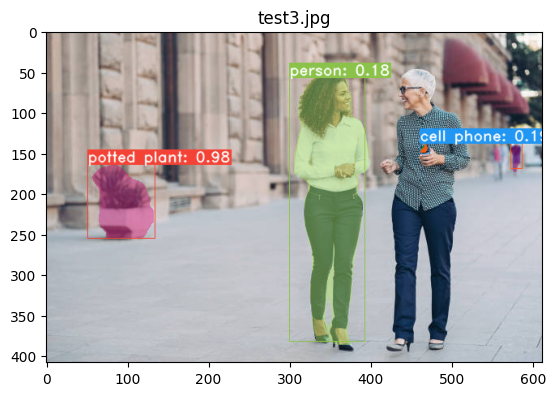

In [15]:
args.image="test3.jpg"
with torch.no_grad():
    if not os.path.exists('results'):
        os.makedirs('results')

    if args.cuda:
        # cudnn.benchmark = True
        # cudnn.fastest = True
        # torch.set_default_tensor_type('torch.cuda.FloatTensor')
        torch.set_default_tensor_type('torch.FloatTensor')
    else:
        torch.set_default_tensor_type('torch.FloatTensor')

    if args.resume and not args.display:
        with open(args.ap_data_file, 'rb') as f:
            ap_data = pickle.load(f)
        calc_map(ap_data)
        exit()

    if args.cuda:
    # net = net.cuda()
        net = net
    evaluate(net, dataset=None)

In [16]:
with torch.no_grad():
    if not os.path.exists('results'):
        os.makedirs('results')

    if args.cuda:
        # cudnn.benchmark = True
        # cudnn.fastest = True
        # torch.set_default_tensor_type('torch.cuda.FloatTensor')
        torch.set_default_tensor_type('torch.FloatTensor')
    else:
        torch.set_default_tensor_type('torch.FloatTensor')

    if args.resume and not args.display:
        with open(args.ap_data_file, 'rb') as f:
            ap_data = pickle.load(f)
        calc_map(ap_data)
        exit()

    if args.cuda:
    # net = net.cuda()
        net = net
    # evaluate(net, dataset=None)
    evalimage(net, "test1.jpg", "out.jpg")